In [1046]:
import pandas as pd
import os
import nltk
import re
nltk.download('stopwords')
from pandas_profiling import ProfileReport
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import string
import zeyrek


%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LENOVO\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Check current Directory ###
and read the xlsx file

In [ ]:
current_directory = os.getcwd()
print(current_directory) 

In [ ]:
filepath2 = "NLP/SoftwareRequest.xlsx"
data2 = pd.read_excel(filepath2)
data2 #checking the file initially

## Initial Analysis ##

Columns data type and nulls

In [1049]:
data2.info() #data info of the dataset in general

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3434 entries, 0 to 3433
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Issue Type                     3434 non-null   object 
 1   Key                            3434 non-null   object 
 2   Linked Issues                  2567 non-null   object 
 3   Summary                        3434 non-null   object 
 4   Status                         3434 non-null   object 
 5   Assignable Responsible Group   659 non-null    object 
 6   Assignee                       3434 non-null   object 
 7   Creator                        3434 non-null   object 
 8   Reporter                       3434 non-null   object 
 9   Priority                       3434 non-null   object 
 10  Resolution                     3434 non-null   object 
 11  Created                        3434 non-null   object 
 12  Updated                        3434 non-null   o

In [1050]:
data2.isnull().sum()

Issue Type                          0
Key                                 0
Linked Issues                     867
Summary                             0
Status                              0
Assignable Responsible Group     2775
Assignee                            0
Creator                             0
Reporter                            0
Priority                            0
Resolution                          0
Created                             0
Updated                             0
Due Date                         3434
Development                      3434
Jira Project                     3434
Resolved                            0
Resolution Detail                   2
Service Request SLA Category        0
Description                         0
Description Message              3434
Kurulumu istenen uygulama adı    3434
dtype: int64

### Check Default TR Stopwords and Include some Additions ###

In [1051]:
TR_stopwords = stopwords.words('Turkish') #get the Turkish stopwords
print(TR_stopwords) #check which words are included in nltk turkish stopwords
print(len(TR_stopwords))

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani']
53


Add some more

In [1052]:
extr1=[line.strip() for line in open('stop_words_turkish.txt',encoding='utf-8')] #https://github.com/tkorkunckaya/Turkish-Stopwords/blob/master/stopwords/mongo/stop_words_turkish.txt
extr2=[line.strip() for line in open('turkce-stop-words.txt',encoding='utf-8')]  #https://github.com/sgsinclair/trombone/blob/master/src/main/resources/org/voyanttools/trombone/keywords/stop.tr.turkish-lucene.txt
for i in range (0, len(extr1)):
    if extr1[i] not in TR_stopwords:
        TR_stopwords.append(extr1[i])
for i in range (0, len(extr2)):
    if extr2[i] not in TR_stopwords:
        TR_stopwords.append(extr2[i])

In [1053]:
print(TR_stopwords) #check which words are included in nltk turkish stopwords
print(len(TR_stopwords))

['acaba', 'ama', 'aslında', 'az', 'bazı', 'belki', 'biri', 'birkaç', 'birşey', 'biz', 'bu', 'çok', 'çünkü', 'da', 'daha', 'de', 'defa', 'diye', 'eğer', 'en', 'gibi', 'hem', 'hep', 'hepsi', 'her', 'hiç', 'için', 'ile', 'ise', 'kez', 'ki', 'kim', 'mı', 'mu', 'mü', 'nasıl', 'ne', 'neden', 'nerde', 'nerede', 'nereye', 'niçin', 'niye', 'o', 'sanki', 'şey', 'siz', 'şu', 'tüm', 've', 'veya', 'ya', 'yani', 'amma', 'anca', 'ancak', 'dahi', 'emme', 'fakat', 'gah', 'gerek', 'hakeza', 'halbuki', 'hatta', 'hele', 'hoş', 'imdi', 'ister', 'kah', 'keşke', 'keza', 'kezalik', 'lakin', 'madem', 'mademki', 'mamafih', 'meğer', 'meğerki', 'meğerse', 'netekim', 'neyse', 'nitekim', 'oysa', 'oysaki', 'şayet', 'velev', 'velhasıl', 'velhasılıkelam', 'veyahut', 'yahut', 'yalnız', 'yok', 'yoksa', 'zira', 'acep', 'açıkça', 'açıkçası', 'adamakıllı', 'adeta', 'bazen', 'bilcümle', 'binaen', 'binaenaleyh', 'bir', 'biraz', 'birazdan', 'birden', 'birdenbire', 'birice', 'birlikte', 'bitevi', 'biteviye', 'bittabi', 'bizati

In [1054]:
#data2['PreProcessed']=data2['PreProcessed'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

### Tokenize, Remove Stopwords, Detokenize, Extract Verbs, Lower, Remove Punctuations (case) ###

In [ ]:
data2['No_SW_Lowered'] =  data2['Description'].apply(str.lower) #lowercase
data2['No_SW_Lowered'] = data2['No_SW_Lowered'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
data2['tokenized_text'] = data2['No_SW_Lowered'].apply(word_tokenize) #tokenize the description

temporaly = data2['tokenized_text'].copy()
tempverb = data2['tokenized_text'].copy()

#data2['tokens_without_sw'] = [word for word in data2['tokenized_text'] if word not in TR_stopwords] #remove the stopwords from tokens
Verb_Checker = ('mak','mek','mesi','ması','mesini','masını','ıyorum','iyorum','makta','mekte','ğımız','ğimiz','bilmem','upgrade','install','setup','erim','ederim','kurulumu','iyor','ıyor','mam','mem','kullanmam','mış','miş','update') #arım and ma me gives error

for i in range(0,len(temporaly.index)): 
    singleDescription = temporaly[i]
    result = ' '.join(word for word in singleDescription if word not in TR_stopwords and not word.endswith(Verb_Checker) and not word.startswith("kullanı") and not word.startswith("yük") and not word.startswith("misin"))
    result2 = ' '.join(word for word in singleDescription if word.endswith(tuple(Verb_Checker)))
    #result = ' '.join(word for word in singleDescription if word not in TR_stopwords)  -- default
    temporaly[i] = result
    tempverb[i] = result2

data2['tokens_without_sw'] = temporaly 
data2['Verbs'] = tempverb

#data2['tokens_without_sw'] = data2['tokens_without_sw'].apply(TreebankWordDetokenizer().detokenize) #back to proper sentences
data2['No_SW_Lowered'] = data2['tokens_without_sw']
data2 = data2.drop(columns = "tokenized_text") #drop the previously created, unnecessary columns
data2 = data2.drop(columns = "tokens_without_sw")
data2.head()

### Initial Word Frequency Analysis (After Stopwords Reduction) ###

In [1056]:
new_df = data2['No_SW_Lowered'].str.replace('[^\w\s]','', regex=True).str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency'] 
pd.set_option("display.max_rows", 50, "display.max_columns", None)
new_df

,Word,Frequency
0,rica,2289
1,bilgisayarıma,690
2,merhaba,690
3,programının,483
4,konusunda,334
...,...,...
7155,zooma,1
7156,a00169646,1
7157,ekibinden,1
7158,geçmişte,1


### Lemmatizing ###

In [ ]:
analiz = zeyrek.MorphAnalyzer()
prelemm = data2['No_SW_Lowered'].apply(word_tokenize).copy()

for i in range(0,len(prelemm.index)): 
    singleDescription = prelemm[i]
    
    thewords = []
    for word in singleDescription:
        def containsNumber(value):
            for character in value:
                if character.isdigit():
                    return True
                return False
        if word == "yeni":
            thewords.append(word)
            continue
        if word == "hakkında":
            thewords.append(word)
            continue
        if(containsNumber(word) == False):
            lem_tuple = analiz.lemmatize(word)
            if len(lem_tuple) != 0:
                listlem = lem_tuple[0]
                if len(listlem[1]) > 1:
                    thewords.append(listlem[1][1])
                    continue
                else:
                    thewords.append(listlem[1][0])
                    continue
            else:
                thewords.append(word)
                continue
        else:
            thewords.append(word)
            continue

    result = ' '.join(word for word in thewords)
    #result = ' '.join(word for word in singleDescription if word not in TR_stopwords)  -- default
    prelemm[i] = result

data2['After_Lemmatized'] = prelemm
data2['After_Lemmatized'] = data2['After_Lemmatized'].apply(str.lower) #lowercase
data2.head()

### Initial Word Frequency Analysis (After Lemmatizing) ###

In [1058]:
new_df2 = data2['After_Lemmatized'].str.replace('[^\w\s]','', regex=True).str.split(expand=True).stack().value_counts().reset_index()
new_df2.columns = ['Word', 'Frequency'] 
pd.set_option("display.max_rows", 50, "display.max_columns", None)
new_df2

,Word,Frequency
0,rica,2302
1,bilgisayar,1157
2,program,1003
3,merhaba,820
4,yardım,562
...,...,...
5194,dikk,1
5195,shop,1
5196,a00169651,1
5197,altınbaş,1


### Word Frequency Bar Chart - With and Without Lemmatizing ###

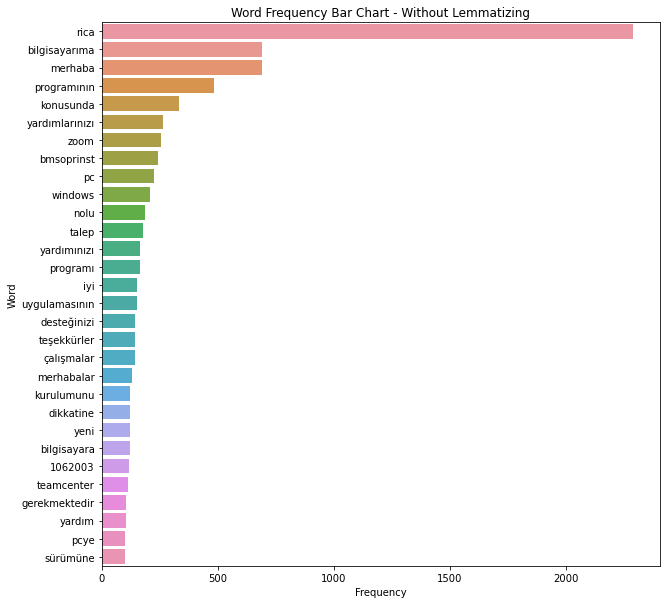

In [1059]:
df_plot=new_df.head(30)
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=df_plot).set_title('Word Frequency Bar Chart - Without Lemmatizing')
plt.show()

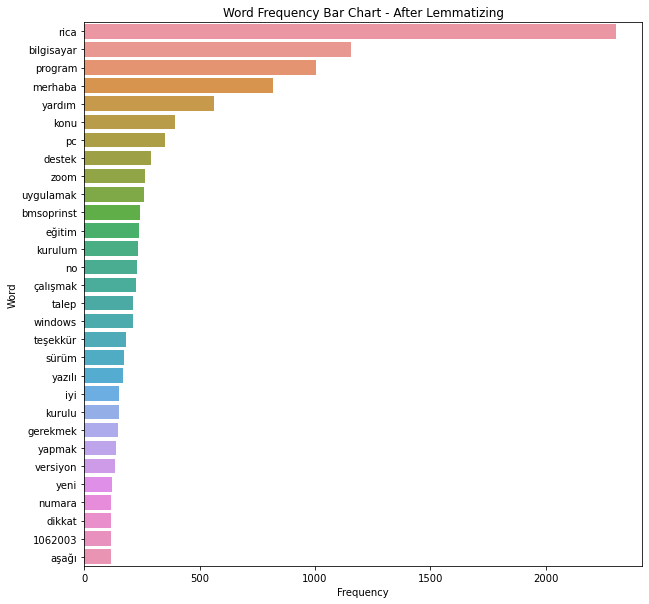

In [1060]:
df_plot=new_df2.head(30)
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=df_plot).set_title('Word Frequency Bar Chart - After Lemmatizing')
plt.show()

### Remove Assets ###

In [ ]:
Descx = data2['After_Lemmatized']
temp_copy = Descx.copy()

for i in range(0,len(Descx .index)): 
    singleDescription = Descx [i]
    splittedDesc = singleDescription.split()# split, splits the string on delimiter, by default its whitespace
    result = ' '.join(word for word in splittedDesc if (word[0:2]!='a0'))
    temp_copy [i] = result
data2['Asset_Removed'] = temp_copy 
data2.head()

In [1062]:
data2.loc[[99]]

,Issue Type,Key,Linked Issues,Summary,Status,Assignable Responsible Group,Assignee,Creator,Reporter,Priority,Resolution,Created,Updated,Due Date,Development,Jira Project,Resolved,Resolution Detail,Service Request SLA Category,Description,Description Message,Kurulumu istenen uygulama adı,No_SW_Lowered,Verbs,After_Lemmatized,Asset_Removed
99,Service Request,SM-52981,NaN,Software Install / Uninstall,CLOSED,Çerkezköy Kurutucu User Support,Hasan Şafak Tetik,Hasan Şafak Tetik,Baran Cömert,Normal,Done,22/Feb/21 12:16 PM,26/Jul/21 1:23 PM,NaN,NaN,NaN,22/Feb/21 12:18 PM,sap kaldırıldı,T1,A00104011'den sap kaldırılması,NaN,NaN,a00104011den sap,kaldırılması,a00104011den sapmak,sapmak


### Extract Software Names, Remove Common Words, Extract Words with Numbers (Potential Software Version), and Extract The Manually Selected Details ###

In [ ]:
data2['temp'] = data2['Asset_Removed'].apply(word_tokenize) #tokenize the description

Cowords = [line.strip() for line in open('Cowords.txt',encoding='utf-8')]
Softnames = [line.strip() for line in open('manualsoftnames.txt',encoding='utf-8')]
Potnames = [line.strip() for line in open('potnames.txt',encoding='utf-8')]
Verb_Checker = ('mak','mek','mesi','ması','mesini','masını','ıyorum','iyorum','makta','mekte','ğımız','ğimiz','bilmem','upgrade','install','setup','erim','ederim','kurulumu','iyor','ıyor','mam','mem','kullanmam','mış','miş','update') #arım and ma me gives error


temporaly = data2['temp'].copy()
tempverb = data2['temp'].copy()
tempother = data2['temp'].copy()
tempsoft = data2['temp'].copy()
tempvers = data2['temp'].copy()

for i in range(0,len(temporaly.index)): 
    singleDescription = temporaly[i]
    result2 = ' '.join(word for word in singleDescription if word.endswith(tuple(Verb_Checker)) and not word.startswith(tuple(Cowords)) and not word.startswith(tuple(Softnames)) and word not in Potnames)
    result3 = ' '.join(word for word in singleDescription if word in Potnames)
    result4 = ' '.join(word for word in singleDescription if word.startswith(tuple(Softnames)))
    result5 = ' '.join(word for word in singleDescription if any(map(str.isdigit, word)))
    result = ' '.join(word for word in singleDescription if not word.startswith(tuple(Cowords)) and not word in TR_stopwords and not word.endswith(tuple(Verb_Checker)) and not any(map(str.isdigit, word)) and not word.startswith(tuple(Softnames)) and not word in Potnames)
    temporaly[i] = result
    tempverb[i] = result2
    tempother[i] = result3
    tempsoft[i] = result4
    tempvers[i] = result5
    
data2['PreProcessed'] = temporaly 
data2['Software Name'] = tempsoft
data2['Software Version / Numeric'] = tempvers
data2['Other Detail'] = tempother
data2['Verb Used - After Lemm'] = tempverb
#data2["Verbs Used"] = data2['Verbs'].astype(str) + data2['Verb Used - After Lemm'].astype(str)
#data2 = data2.drop(columns = 'Verbs')
#data2 = data2.drop(columns = "Verb Used - After Lemm")
data2 = data2.drop(columns = "temp")
data2

In [1064]:
data2["Verbs Used"] = data2['Verbs'] + ' ' + data2["Verb Used - After Lemm"]

In [1065]:
data2 = data2.drop(columns = 'Verbs')
data2 = data2.drop(columns = "Verb Used - After Lemm")
data2 = data2.drop(columns = "No_SW_Lowered")
data2 = data2.drop(columns = "After_Lemmatized")
data2 = data2.drop(columns = "Asset_Removed")

### Remove Punctuations ###

### Preprocessed Data ###

In [ ]:
data2

### Word Frequency After Removing Some Common Words ###

In [1067]:
new_df = data2['PreProcessed'].str.replace('[^\w\s]','', regex=True).str.split(expand=True).stack().value_counts().reset_index() #in case punctuation was previously needed / unremoved
soft_df = data2['Software Name'].str.replace('[^\w\s]','', regex=True).str.split(expand=True).stack().value_counts().reset_index()
verb_df = data2['Verbs Used'].str.replace('[^\w\s]','', regex=True).str.split(expand=True).stack().value_counts().reset_index()
new_df.columns = ['Word', 'Frequency']
verb_df.columns = ['Word', 'Frequency']
soft_df.columns = ['Word', 'Frequency']
pd.set_option("display.max_rows", 50, "display.max_columns", None) #50 set to None for Full Viewing
new_df

,Word,Frequency
0,proje,115
1,iyi,109
2,dosya,100
3,sistem,91
4,asset,88
...,...,...
3264,nicelabelpro,1
3265,goo,1
3266,sunu,1
3267,aracı,1


### Unique Words - Possible Target words for lemmitizing/stemming ###

In [1068]:
new_df.loc[new_df['Frequency'] == 1]

,Word,Frequency
1432,occurs,1
1433,reset,1
1434,ica,1
1435,however,1
1436,zâfir,1
...,...,...
3264,nicelabelpro,1
3265,goo,1
3266,sunu,1
3267,aracı,1


### Bar Charts - Latest Word Frequency, Software Names, Verbs ###

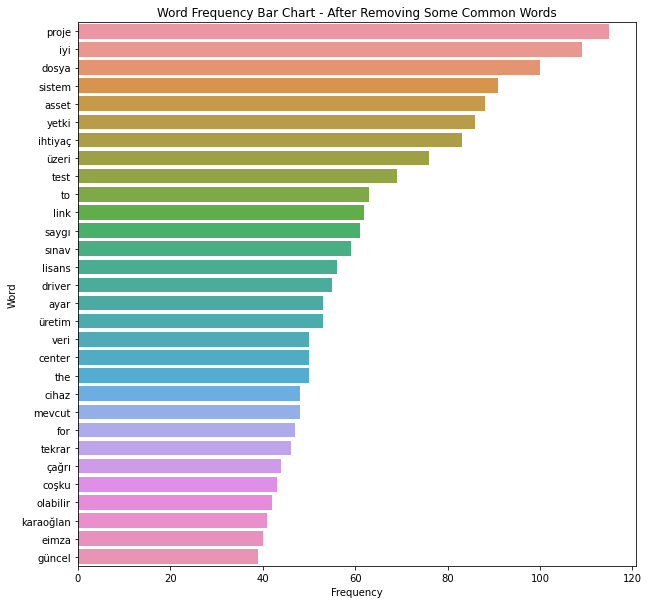

In [1069]:
df_plot=new_df.head(30)
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=df_plot).set_title('Word Frequency Bar Chart - After Removing Some Common Words')
plt.show()

Note : Software Names are not removed from the description, just copied

Verb Chart - May be Useful to learn what's being asked with the software

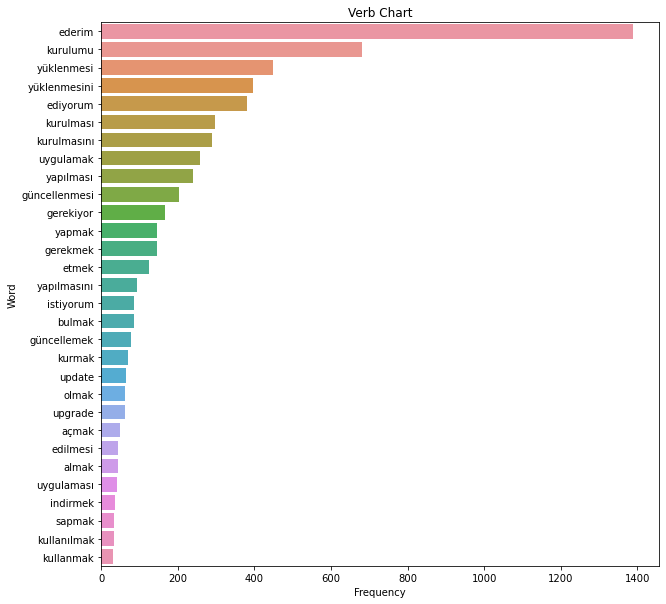

In [1070]:
df_plot=verb_df.head(30)
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=df_plot).set_title('Verb Chart')
plt.show()

### Bar Charts - Software Name ###

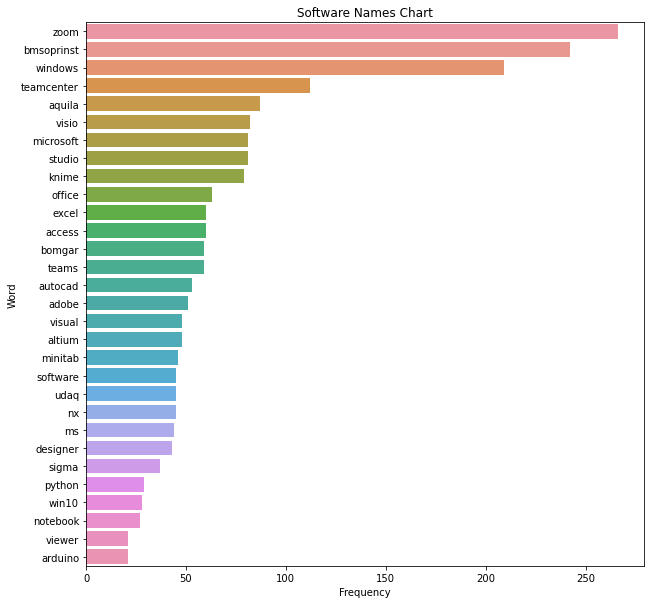

In [1071]:
df_plot=soft_df.head(30)
plt.figure(figsize=(10, 10))
sns.barplot(x='Frequency', y='Word', data=df_plot).set_title('Software Names Chart')
plt.show()

In [1072]:
type(new_df)

pandas.core.frame.DataFrame

In [1073]:
data2["Resolved"]

0        26/Feb/21 5:12 PM
1        26/Feb/21 3:55 PM
2        26/Feb/21 4:42 PM
3        26/Feb/21 4:07 PM
4        26/Feb/21 4:07 PM
               ...        
3429    03/Jun/21 10:54 AM
3430     03/Jun/21 8:15 AM
3431     17/Jun/21 5:08 PM
3432     08/Jun/21 8:18 AM
3433     01/Jun/21 9:47 AM
Name: Resolved, Length: 3434, dtype: object

In [1074]:
data2.to_excel("output1.xlsx")

In [ ]:
Times = data2["Resolved"]
timelist = Times.copy()
for i in range(0,len(Times.index)):
    aTime = Times[i]
    splittedtime =  aTime.split()
    result = ' '.join(word[0])
    timelist[i] = result


In [ ]:
data2['FeatureExtraction'] = data2['PreProcessed']
#Counter(data2['FeatureExtraction'])